# Reinforcement Learning: Assignment 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Visualize the grid world
def plot_grid_world(grid_world, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(1-grid_world, cmap='gray', interpolation='nearest')
    plt.title("Grid World")
    plt.xticks([])
    plt.yticks([])
    plt.show()


# Visualize the grid world, state value function, and policy
def plot_policy(grid_world, policy=None, figsize=(10,3), title="Policy"):
    plt.figure(figsize=figsize)
    
    if policy is not None:
        plt.imshow(1-grid_world, cmap='gray')
        n_x, n_y, n_a = policy.shape
        for i in range(n_x):
            for j in range(n_y):
                if grid_world[i, j] == 1 or grid_world[i, j] == 2:
                    continue
                if policy[i, j, 0] > 0:
                    plt.arrow(j, i,      0 * policy[i, j, 0], -0.5 * policy[i,j,0], head_width=0.1, head_length=0.1, fc='r', ec='r')
                if policy[i, j, 1] > 0:
                    plt.arrow(j, i,    0.5 * policy[i, j, 1],    0 * policy[i,j,1], head_width=0.1, head_length=0.1, fc='r', ec='r')
                if policy[i, j, 2] > 0:
                    plt.arrow(j, i,      0 * policy[i, j, 2], +0.5 * policy[i,j,2], head_width=0.1, head_length=0.1, fc='r', ec='r')
                if policy[i, j, 3] > 0:
                    plt.arrow(j, i,   -0.5 * policy[i, j, 3],    0 * policy[i,j,3], head_width=0.1, head_length=0.1, fc='r', ec='r')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

    plt.show()

### Monte Carlo Control

In [3]:
import numpy as np

def generate_episode(Terminal_states=[], T_max=1000):
    S = []
    A = []
    R = []

    # Random initial state
    S.append((np.random.randint(4), np.random.randint(4)))

    if S[-1] in Terminal_states:
        A.append(0)
        R.append(0)
    else:
        A.append(np.random.randint(4))
        R.append(-1)
    
    while S[-1] not in Terminal_states:
        if A[-1] == 0:
            next_state = (max(0, S[-1][0]-1), S[-1][1])
        elif A[-1] == 1:
            next_state = (S[-1][0], min(3, S[-1][1]+1))
        elif A[-1] == 2:
            next_state = (min(3, S[-1][0]+1), S[-1][1])
        elif A[-1] == 3:
            next_state = (S[-1][0], max(0, S[-1][1]-1))
        
        S.append(next_state)

        if S[-1] in Terminal_states:
            A.append(0)
            R.append(0)
        else:
            A.append(np.random.randint(4))
            R.append(-1)
    
    return S, A, R


In [4]:
def MC_control(Terminal_states=[], n_episodes=1000):
    # Initialize
    Q = np.ones((4, 4, 4))*-3
    C = np.zeros((4, 4, 4))
    policy = np.zeros((4, 4, 4))
    policy[:, :, 0] = 1

    # Loop for each episode
    for _ in range(n_episodes):
        # Generate an episode
        S, A, R = generate_episode(Terminal_states)
        G = 0
        W = 1
        # Loop for each step of episode
        for t in range(len(S)-1, -1, -1):
            G = 0.9*G + R[t]
            C[S[t][0], S[t][1], A[t]] += W
            Q[S[t][0], S[t][1], A[t]] += W/C[S[t][0], S[t][1], A[t]]*(G-Q[S[t][0], S[t][1], A[t]])
            idx = np.argmax(Q[S[t][0], S[t][1]])
            policy[S[t][0], S[t][1]] = 0
            policy[S[t][0], S[t][1], idx] = 1
            if idx != A[t]:
                break
            W = W/0.25
    
    return policy

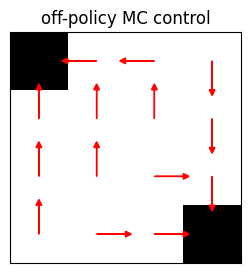

In [5]:
# Grid World                                    4x4 Matrix
grid_world = np.zeros((4,4))

# Terminal States
Terminal_states = []
Terminal_states.append((0,0))         # Append Terminal State
Terminal_states.append((3,3))         # Append Terminal State

for t in Terminal_states:
    grid_world[t] = 1


policy = MC_control(Terminal_states, n_episodes=1000)
plot_policy(grid_world=grid_world, policy=policy, title="off-policy MC control")

### Monte Carlo Control - Another Setting

In [6]:
import numpy as np

def generate_episode(Terminal_states=[], T_max=1000):
    S = []
    A = []
    R = []

    # Random initial state
    S.append((np.random.randint(4), np.random.randint(4)))

    if S[-1] in Terminal_states:
        A.append(0)
        R.append(1)
    else:
        A.append(np.random.randint(4))
        R.append(0)
    
    for _ in range(T_max):
        if S[-1] in Terminal_states:
            break
        elif A[-1] == 0:
            next_state = (max(0, S[-1][0]-1), S[-1][1])
        elif A[-1] == 1:
            next_state = (S[-1][0], min(3, S[-1][1]+1))
        elif A[-1] == 2:
            next_state = (min(3, S[-1][0]+1), S[-1][1])
        elif A[-1] == 3:
            next_state = (S[-1][0], max(0, S[-1][1]-1))
        
        S.append(next_state)

        if S[-1] in Terminal_states:
            A.append(0)
            R.append(1)
        else:
            A.append(np.random.randint(4))
            R.append(0)
    
    return S, A, R


In [7]:
def MC_control(Terminal_states=[], n_episodes=1000):
    # Initialize
    Q = np.zeros((4, 4, 4))
    C = np.zeros((4, 4, 4))
    policy = np.zeros((4, 4, 4))
    policy[:, :, 0] = 1

    # Loop for each episode
    for _ in range(n_episodes):
        # Generate an episode
        S, A, R = generate_episode(Terminal_states)
        G = 0
        W = 1
        # Loop for each step of episode
        for t in range(len(S)-1, -1, -1):
            G = 0.9*G + R[t]
            C[S[t][0], S[t][1], A[t]] += W
            Q[S[t][0], S[t][1], A[t]] += W/C[S[t][0], S[t][1], A[t]]*(G-Q[S[t][0], S[t][1], A[t]])
            idx = np.argmax(Q[S[t][0], S[t][1]])
            policy[S[t][0], S[t][1]] = 0
            policy[S[t][0], S[t][1], idx] = 1
            if idx != A[t]:
                break
            W = W/0.25
    
    return policy

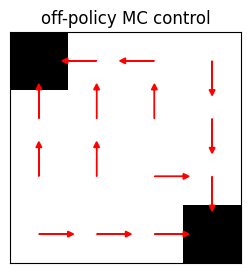

In [8]:
# Grid World                                    4x4 Matrix
grid_world = np.zeros((4,4))

# Terminal States
Terminal_states = []
Terminal_states.append((0,0))         # Append Terminal State
Terminal_states.append((3,3))         # Append Terminal State

for t in Terminal_states:
    grid_world[t] = 1


policy = MC_control(Terminal_states, n_episodes=1000)
plot_policy(grid_world=grid_world, policy=policy, title="off-policy MC control")

### Grid world with cliff

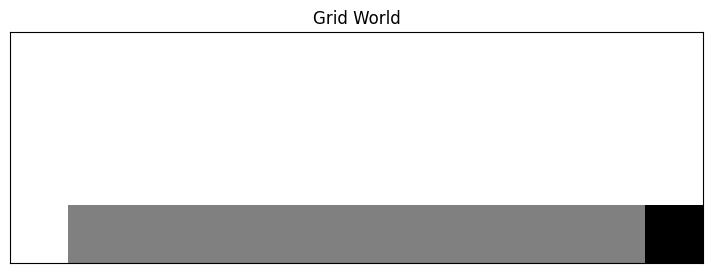

In [9]:
# Grid world with cliff                         4x12 Matrix
grid_world = np.zeros((4,12))
grid_world[3,11] = 2            # goal
grid_world[3,1:11] = 1          # cliff

plot_grid_world(grid_world, figsize=(10,3))

### Tabular Sarsa

In [10]:
def Sarsa(step_size=0.9, epsilon=0.1, n_episodes=1000):
    # Initialize Q(s,a)
    Q = np.zeros((4,12,4))
    Q[3,11] = 10
    Q[3,1:11] = -100

    for n in range(n_episodes):
        # Fixed initial state
        S = [3,0]

        

        # Choose A from S using policy derived from Q (epsilon-greedy)
        if np.random.rand() < epsilon:
            A = np.random.randint(4)
        else:
            A = np.argmax(Q[S[0], S[1]])
        
        # Repeat for each step of episode
        while S != [3,11]:
            # Take action A, observe R, S'

            if S[0] == 3 and 1 <= S[1] <= 10:
                S_next = [3,0]
                R = -100
            else:
                if A == 0:
                    S_next = [max(0, S[0]-1), S[1]]
                elif A == 1:
                    S_next = [S[0], min(11, S[1]+1)]
                elif A == 2:
                    S_next = [min(3, S[0]+1), S[1]]
                elif A == 3:
                    S_next = [S[0], max(0, S[1]-1)]
                R = -1

            # Choose A' from S' using policy derived from Q (epsilon-greedy)
            if np.random.rand() < epsilon:
                A_next = np.random.randint(4)
            else:
                A_next = np.argmax(Q[S_next[0], S_next[1]])
            
            # Q update
            Q[S[0], S[1], A] += step_size * (R + Q[S_next[0], S_next[1], A_next] - Q[S[0], S[1], A])

            S = S_next
            A = A_next

    policy = np.zeros((4,12,4))
    for i in range(4):
        for j in range(12):
            idx = np.argmax(Q[i,j])
            policy[i,j,idx] = 1
    
    return policy

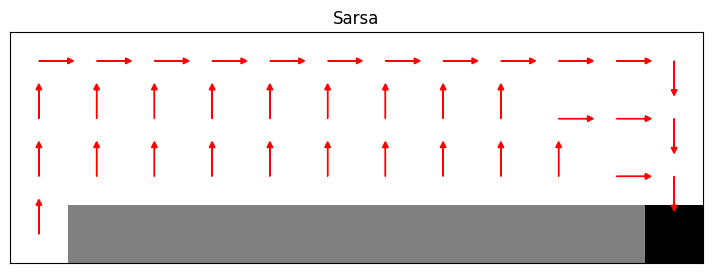

In [11]:
# Grid world with cliff                         4x12 Matrix
grid_world = np.zeros((4,12))
grid_world[3,11] = 2            # goal
grid_world[3,1:11] = 1          # cliff


policy = Sarsa(step_size=0.1, epsilon=0.5, n_episodes=10000)
plot_policy(grid_world, policy, title="Sarsa")

### Tabular Q-learning

In [12]:
def Q_learning(step_size=0.9, epsilon=0.1, n_episodes=1000):
    # Initialize Q(s,a)
    Q = np.zeros((4,12,4))
    Q[3,11] = 10
    Q[3,1:11] = -100

    for n in range(n_episodes):
        # Initialize S
        S = [3,0]

        # Repeat for each step of episode
        while S != [3,11]:
            # Choose A from S using policy derived from Q (epsilon-greedy)
            if np.random.rand() < epsilon:
                A = np.random.randint(4)
            else:
                A = np.argmax(Q[S[0], S[1]])
            
            # Take action A, observe R, S'
            if S[0] == 3 and 1 <= S[1] <= 10:
                S_next = [3,0]
                R = -100
            else:
                if A == 0:
                    S_next = [max(0, S[0]-1), S[1]]
                elif A == 1:
                    S_next = [S[0], min(11, S[1]+1)]
                elif A == 2:
                    S_next = [min(3, S[0]+1), S[1]]
                elif A == 3:
                    S_next = [S[0], max(0, S[1]-1)]
                R = -1
            
            # Q update
            Q[S[0], S[1], A] += step_size * (R + np.max(Q[S_next[0], S_next[1]]) - Q[S[0], S[1], A])

            S = S_next

    policy = np.zeros((4,12,4))
    for i in range(4):
        for j in range(12):
            idx = np.argmax(Q[i,j])
            policy[i,j,idx] = 1

    return policy

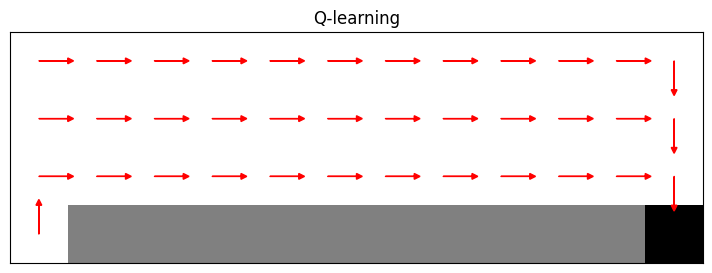

In [18]:
# Grid world with cliff                         4x12 Matrix
grid_world = np.zeros((4,12))
grid_world[3,11] = 2            # goal
grid_world[3,1:11] = 1          # cliff


policy = Q_learning(step_size=0.1, epsilon=0.5, n_episodes=20000)
plot_policy(grid_world, policy, title="Q-learning")